## **Problem Statement**

> **QUESTION**: The [Rain in Australia dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) contains about 10 years of daily weather observations from numerous Australian weather stations. As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow.

## **Outline**

- Downloading a real-world dataset from Kaggle
- Exploratory data analysis and visualization
- Splitting a dataset into training, validation & test sets
- Filling/imputing missing values in numeric columns
- Scaling numeric features to a $(0,1)$ range
- Encoding categorical columns as one-hot vectors
- Training a logistic regression model using Scikit-learn
- Evaluating a model using a validation set and test set
- Saving a model to disk and loading it back

## **Introduction**

Identifying whether a given problem is a _classfication_ or _regression_ problem is an important first step in machine learning.

### **Regression Problems**

Problems where a continuous numeric value must be predicted for each input are known as _regression problems_.

Here are some example of regression problems:

- [Medical Charges Prediction](https://www.kaggle.com/subhakarks/medical-insurance-cost-analysis-and-prediction)
- [House Price Prediction](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) 
- [Ocean Temperature Prediction](https://www.kaggle.com/sohier/calcofi)
- [Weather Temperature Prediction](https://www.kaggle.com/budincsevity/szeged-weather)

### **Classification Problems**

Problems where each input must be assigned a discrete category (also called label or class) are known as _classification problems_. 

Here are some examples of classification problems:

- [Rainfall prediction](https://kaggle.com/jsphyg/weather-dataset-rattle-package): Predicting whether it will rain tomorrow using today's weather data (classes are "Will Rain" and "Will Not Rain")
- [Breast cancer detection](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data): Predicting whether a tumor  is "benign" (noncancerous) or "malignant" (cancerous) using information like its radius, texture etc.
- [Loan Repayment Prediction](https://www.kaggle.com/c/home-credit-default-risk) - Predicting whether applicants will repay a home loan based on factors like age, income, loan amount, no. of children etc.
- [Handwritten Digit Recognition](https://www.kaggle.com/c/digit-recognizer) - Identifying which digit from 0 to 9 a picture of handwritten text represents.

Classification problems can be binary or multiclass (picking one of many classes).

> #### **_logistic regression_ is better suited for _binary classification_ problems like predicting whether it will rain tomorrow or not.**

### **Linear Regression for Solving Regression Problems**

Linear regression is a commonly used technique for solving regression problems. 
In a linear regression model, the target is modeled as a linear combination (or weighted sum) of input features. 
The predictions from the model are evaluated using a loss function like the Root Mean Squared Error (RMSE).

Here's a visual summary of how a linear regression model is structured:

<img src="https://i.imgur.com/iTM2s5k.png" width="480">


### **Logistic Regression for Solving Classification Problems**

Logistic regression is a commonly used technique for solving binary classification problems.

In a logistic regression model: 

- we take linear combination (or weighted sum of the input features) 
- we apply the sigmoid function to the result to obtain a number between 0 and 1
- this number represents the probability of the input being classified as "Yes"
- instead of RMSE, the cross entropy loss function is used to evaluate the results


Here's a visual summary of how a logistic regression model is structured:

<img src="https://i.imgur.com/YMaMo5D.png" width="480">

The sigmoid function applied to the linear combination of inputs has the following formula:

<img src="https://i.imgur.com/sAVwvZP.png" width="400">


The output of the sigmoid function is called a logistic, hence the name _logistic regression_. 

Logistic regression can also be applied to multi-class classification problems, with a few modifications.

## **Machine Learning Workflow**

Whether we're solving a regression problem using linear regression or a classification problem using logistic regression, the workflow for training a model is exactly the same:

1. We initialize a model with random parameters (weights & biases).
2. We pass some inputs into the model to obtain predictions.
3. We compare the model's predictions with the actual targets using the loss function.  
4. We use an optimization technique (like least squares, gradient descent etc.) to reduce the loss by adjusting the weights & biases of the model
5. We repeat steps 1 to 4 till the predictions from the model are good enough.


<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">


Classification and regression are both supervised machine learning problems, because they use labeled data. 
Machine learning applied to unlabeled data is known as unsupervised learning. 

<img src="https://i.imgur.com/1EMQmAw.png" width="480">


We'll train a _logistic regression_ model using the Rain in Australia dataset to predict whether or not it will rain at a location tomorrow, using today's data. This is a _binary classification_ problem.

## **Importing Dependencies**

In [62]:
import opendatasets as od
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

## **Downloading the Data**

We'll use the [`opendatasets` library](https://github.com/JovianML/opendatasets) to download the data from Kaggle directly within Jupyter. Let's install and import `opendatasets`.

```py
dataset_url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'
od.download(dataset_url)
```

The download will ask for kaggle userid and api key

In [16]:
df = pd.read_csv('./dataset/weatherAUS.csv')
df.sample(5), df.shape

(             Date       Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
 51817  2016-10-24    Tuggeranong      0.7     18.4       0.0          NaN   
 50520  2013-04-06    Tuggeranong      6.3     22.5       0.0          NaN   
 57473  2015-08-27       Ballarat      0.5     12.0       0.2          NaN   
 17001  2014-06-07      Newcastle     11.5     19.0      26.0          NaN   
 5405   2015-09-21  BadgerysCreek      9.5     24.7       0.2          NaN   
 
        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
 51817       NaN           N           26.0        SSW  ...        59.0   
 50520       NaN           E           28.0        NaN  ...        85.0   
 57473       NaN           S           39.0        SSW  ...       100.0   
 17001       NaN         NaN            NaN         SW  ...        66.0   
 5405        NaN         SSW           24.0         SE  ...       100.0   
 
        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \


* The dataset contains over 145,000 rows and 23 columns. 
* The dataset contains date, numeric and categorical columns. 
* Our objective is to create a model to predict the value in the column `RainTomorrow`.

* Let's check the data types and missing values in the various columns.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

* While we should be able to fill in missing values for most columns, it might be a good idea to discard the rows where the value of `RainTomorrow` or `RainToday` is missing to make our analysis and modeling simpler (since one of them is the target variable, and the other is likely to be very closely related to the target variable). 

In [18]:
df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140787 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           140787 non-null  object 
 1   Location       140787 non-null  object 
 2   MinTemp        140319 non-null  float64
 3   MaxTemp        140480 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81093 non-null   float64
 6   Sunshine       73982 non-null   float64
 7   WindGustDir    131624 non-null  object 
 8   WindGustSpeed  131682 non-null  float64
 9   WindDir9am     131127 non-null  object 
 10  WindDir3pm     137117 non-null  object 
 11  WindSpeed9am   139732 non-null  float64
 12  WindSpeed3pm   138256 non-null  float64
 13  Humidity9am    139270 non-null  float64
 14  Humidity3pm    137286 non-null  float64
 15  Pressure9am    127044 non-null  float64
 16  Pressure3pm    127018 non-null  float64
 17  Cloud9am       88162 non-null

In [14]:
df.describe()

MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.000000      13.000000   
50%        8.400000      39.000000      13.000000      19.000000   
75%       10.600000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm   Pressure9am    Pressure3pm  \
count  142806.000000  140953.000000  130395.00000  130432.000000   
mean       68.880831      51.539116    1017.64994    1015.255889   
std        19.029164      20.795902       7.10653       7.037414   
min         0.000000       0.000000     980.50000     977.100000   
25%        57.000000      37.000000    1012.90000    1010.400000   
50%        70.000000      52.000000    1017.60000    1015.200000   
75%        83.000000      66.000000    1022.40000    1020.000000   
max       100.000000     100.000000    1041.00000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am       Temp3pm  
count  89572.000000  86102.000000  143693.000000  141851.00000  
mean       4.447461      4.509930      16.990631      21.68339  
std        2.887159      2.720357       6.488753       6.93665  
min        0.000000      0.000000      -7.200000      -5.40000  
25%        1.000000      2.000000      12.300000      16.60000  
50%        5.000000      5.000000      16.700000      21.10000  
75%        7.000000      7.000000      21.600000      26.40000  
max        9.000000      9.000000      40.200000      46.70000

## **Exploratory Data Analysis and Visualization**

* Before training a machine learning model, its always a good idea to explore the distributions of various columns and see how they are related to the target column. 
* Let's explore and visualize the data using the Plotly, Matplotlib and Seaborn libraries.

In [20]:
px.histogram(df, x='Location', title='Location vs. Rainy Days', color='RainToday')

In [21]:
px.histogram(df, x='Temp3pm', title='Temperature at 3 pm vs. Rain Tomorrow', color='RainTomorrow')

In [22]:
px.histogram(df, x='RainTomorrow', title='Rain Tomorrow vs. Rain Today', color='RainToday')

### **Working with a Sample**

When working with massive datasets containing millions of rows, it's a good idea to work with a sample initially, to quickly set up your model training notebook.

In [25]:
px.scatter(df.sample(3000), title='Min Temp. vs Max Temp.',x='MinTemp', y='MaxTemp', color='RainToday')

In [26]:
px.scatter(df.sample(3000), title='Temp (3 pm) vs. Humidity (3 pm)', x='Temp3pm', y='Humidity3pm', color='RainTomorrow')

## **Training, Validation and Test Sets**

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using an optimization technique. 


2. **Validation set** - used to evaluate the model during training, tune model hyperparameters (optimization technique, regularization etc.), and pick the best version of the model. Picking a good validation set is essential for training models that generalize well.


3. **Test set** - used to compare different models or approaches and report the model's final accuracy. For many datasets, test sets are provided separately. 
- The test set should reflect the kind of data the model will encounter in the real-world, as closely as feasible.


<img src="https://i.imgur.com/j8eITrK.png" width="480">


As a general rule of thumb you can use around 60% of the data for the training set, 20% for the validation set and 20% for the test set. If a separate test set is already provided, you can use a 75%-25% training-validation split.


When rows in the dataset have no inherent order, it's common practice to pick random subsets of rows for creating test and validation sets. This can be done using the `train_test_split` utility from `scikit-learn`.

In [29]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (84471, 23)
val_df.shape : (28158, 23)
test_df.shape : (28158, 23)


However, while working with dates, it's often a better idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

For the current dataset, we can use the Date column in the dataset to create another column for year. We'll pick the last two years for the test set, and one year before it for the validation set.

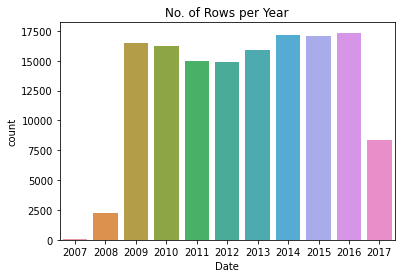

In [30]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(df.Date).dt.year);

In [32]:
year = pd.to_datetime(df.Date).dt.year

train_df = df[year < 2015]
val_df = df[year == 2015]
test_df = df[year > 2015]

print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (97988, 23)
val_df.shape : (17089, 23)
test_df.shape : (25710, 23)


While not a perfect 60-20-20 split, we have ensured that the test validation and test sets both contain data for all 12 months of the year.

In [34]:
train_df.sample(5)

Date      Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
125079  2012-07-10    SalmonGums      0.2     10.7       0.0          NaN   
10584   2013-06-04  CoffsHarbour     12.3     20.9       0.0          4.0   
79625   2013-09-22      Watsonia      9.1     21.6       0.6          4.4   
134796  2013-12-29    Launceston     10.9     21.0       0.0          NaN   
54007   2014-06-27   MountGinini     -0.3      0.9       1.6          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
125079       NaN           N           35.0         NE  ...        81.0   
10584        7.6         SSW           41.0         SW  ...        47.0   
79625        8.9           W           22.0        SSE  ...        88.0   
134796       NaN          NW           35.0        WSW  ...        43.0   
54007        NaN         WNW           61.0        WNW  ...        97.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
125079         77.0          NaN          NaN       NaN       NaN      6.2   
10584          53.0       1024.1       1022.6       3.0       6.0     17.5   
79625          54.0       1012.4       1009.3       7.0       2.0     13.6   
134796         30.0       1009.7       1010.3       NaN       NaN     15.1   
54007          97.0          NaN          NaN       NaN       NaN      0.6   

        Temp3pm  RainToday  RainTomorrow  
125079      9.7         No           Yes  
10584      19.9         No            No  
79625      20.3         No            No  
134796     19.9         No            No  
54007       0.3        Yes            No  

[5 rows x 23 columns]

In [35]:
val_df.sample(5)

Date     Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
141434  2015-02-07       Darwin     26.3     33.2       0.0          7.2   
54295   2015-04-11  MountGinini      3.9     12.9       0.0          NaN   
72530   2015-02-05      Mildura     12.2     31.7       0.0         10.1   
95524   2015-04-22   Townsville     20.1     30.8       0.0          7.6   
38803   2015-06-22   WaggaWagga      1.6     13.2       0.0          1.0   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
141434       7.4         SSW           31.0        ENE  ...        87.0   
54295        NaN          SW           20.0        WNW  ...        97.0   
72530       11.5         SSE           30.0        SSE  ...        56.0   
95524       11.3          SW           33.0        SSW  ...        22.0   
38803        5.8         ENE           19.0        ESE  ...        81.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
141434         56.0       1012.4       1009.2       6.0       4.0     27.9   
54295          77.0          NaN          NaN       NaN       NaN      7.9   
72530          23.0       1020.0       1018.3       0.0       1.0     15.9   
95524          30.0       1015.0       1009.7       1.0       4.0     24.3   
38803          63.0       1029.5       1026.1       5.0       4.0      4.6   

        Temp3pm  RainToday  RainTomorrow  
141434     31.4         No            No  
54295      10.1         No            No  
72530      27.6         No            No  
95524      28.1         No            No  
38803      12.6         No            No  

[5 rows x 23 columns]

In [36]:
test_df.sample(5)

Date      Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
138761  2016-07-11  AliceSprings     11.9     20.7       0.0          5.6   
132650  2016-06-10        Hobart      9.7     11.8       0.0          2.0   
87049   2017-01-26      Brisbane     24.1     32.3       0.0          8.0   
96190   2017-02-16    Townsville     23.7     29.4      38.0         11.6   
72959   2016-04-09       Mildura      8.2     24.6       0.0          4.0   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
138761       NaN         SSW           19.0        SSW  ...        40.0   
132650       1.8         NNW           56.0          N  ...        66.0   
87049       10.9         NNE           26.0         NW  ...        54.0   
96190        NaN           E           61.0          E  ...        94.0   
72959        7.4         SSW           24.0        ESE  ...        49.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
138761         27.0       1019.4       1015.9       NaN       1.0     13.8   
132650         56.0       1004.3       1006.2       5.0       6.0     10.1   
87049          54.0       1014.3       1010.7       4.0       3.0     28.4   
96190          93.0       1012.1       1011.0       8.0       8.0     24.6   
72959          28.0       1024.4       1021.1       5.0       8.0     16.9   

        Temp3pm  RainToday  RainTomorrow  
138761     20.0         No            No  
132650     11.1         No           Yes  
87049      31.1         No           Yes  
96190      23.5        Yes           Yes  
72959      24.0         No            No  

[5 rows x 23 columns]

## **Identifying Input and Target Columns**

Often, not all the columns in a dataset are useful for training a model. 

In the current dataset, we can ignore the `Date` column, since we only want weather conditions to make a prediction about whether it will rain the next day.

Let's create a list of input columns, and also identify the target column.

In [38]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'
print(input_cols)
print(target_col)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']
RainTomorrow


We can now create inputs and targets for the training, validation and test sets for further processing and model training.

In [39]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [40]:
train_inputs.head(0)

Empty DataFrame
Columns: [Location, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, Temp3pm, RainToday]
Index: []

[0 rows x 21 columns]

Let's also identify which of the columns are numerical and which ones are categorical. This will be useful later, as we'll need to convert the categorical data to numbers for training a logistic regression model.

In [43]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

numeric_cols, categorical_cols

(['MinTemp',
  'MaxTemp',
  'Rainfall',
  'Evaporation',
  'Sunshine',
  'WindGustSpeed',
  'WindSpeed9am',
  'WindSpeed3pm',
  'Humidity9am',
  'Humidity3pm',
  'Pressure9am',
  'Pressure3pm',
  'Cloud9am',
  'Cloud3pm',
  'Temp9am',
  'Temp3pm'],
 ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])

In [45]:
train_inputs.describe()

MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  97674.000000  97801.000000  97988.000000  61657.000000  57942.000000   
mean      12.007831     23.022202      2.372935      5.289991      7.609004   
std        6.347175      6.984397      8.518819      3.952010      3.788813   
min       -8.500000     -4.100000      0.000000      0.000000      0.000000   
25%        7.500000     17.900000      0.000000      2.600000      4.800000   
50%       11.800000     22.400000      0.000000      4.600000      8.500000   
75%       16.600000     27.900000      0.800000      7.200000     10.600000   
max       33.900000     48.100000    371.000000     82.400000     14.300000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   91160.000000  97114.000000  96919.000000  96936.000000  96872.000000   
mean       40.215873     14.092263     18.764608     68.628745     51.469547   
std        13.697967      8.984203      8.872398     19.003097     20.756113   
min         6.000000      0.000000      0.000000      0.000000      0.000000   
25%        31.000000      7.000000     13.000000     57.000000     37.000000   
50%        39.000000     13.000000     19.000000     70.000000     52.000000   
75%        48.000000     19.000000     24.000000     83.000000     66.000000   
max       135.000000     87.000000     87.000000    100.000000    100.000000   

        Pressure9am   Pressure3pm      Cloud9am      Cloud3pm       Temp9am  \
count  88876.000000  88857.000000  63000.000000  61966.000000  97414.000000   
mean    1017.513734   1015.132352      4.302952      4.410677     16.835126   
std        7.072510      6.997072      2.866634      2.693370      6.404586   
min      980.500000    979.000000      0.000000      0.000000     -5.900000   
25%     1012.800000   1010.400000      1.000000      2.000000     12.200000   
50%     1017.500000   1015.100000      5.000000      5.000000     16.600000   
75%     1022.300000   1019.900000      7.000000      7.000000     21.400000   
max     1041.000000   1039.600000      9.000000      9.000000     40.200000   

            Temp3pm  
count  97392.000000  
mean      21.540138  
std        6.831612  
min       -5.100000  
25%       16.600000  
50%       20.900000  
75%       26.200000  
max       46.100000

If the ranges of the numeric columns doesn't seem reasonable, we may have to do some data cleaning as well.

Let's also check the number of categories in each of the categorical columns.

In [46]:
train_inputs[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

## Imputing Missing Numeric Data

Machine learning models can't work with missing numerical data. The process of filling missing values is called imputation.

<img src="https://i.imgur.com/W7cfyOp.png" width="480">

There are several techniques for imputation, but we'll use the most basic one: replacing missing values with the average value (mean) in the column using the `SimpleImputer` class from `sklearn.impute`.

The first step in imputation is to `fit` the imputer to the data i.e. compute the chosen statistic (e.g. mean) for each column in the dataset. 

After calling `fit`, the computed statistic for each column is stored in the `statistics_` property of `imputer`.

The missing values in the training, test and validation sets can then be filled in using the `transform` method of `imputer`.

In [48]:
imputer = SimpleImputer(strategy = 'mean')

In [49]:
df[numeric_cols].isna().sum()

MinTemp            468
MaxTemp            307
Rainfall             0
Evaporation      59694
Sunshine         66805
WindGustSpeed     9105
WindSpeed9am      1055
WindSpeed3pm      2531
Humidity9am       1517
Humidity3pm       3501
Pressure9am      13743
Pressure3pm      13769
Cloud9am         52625
Cloud3pm         56094
Temp9am            656
Temp3pm           2624
dtype: int64

These values are spread across the training, test and validation sets. You can also check the no. of missing values individually for `train_inputs`, `val_inputs` and `test_inputs`.

In [50]:
train_inputs[numeric_cols].isna().sum()

MinTemp            314
MaxTemp            187
Rainfall             0
Evaporation      36331
Sunshine         40046
WindGustSpeed     6828
WindSpeed9am       874
WindSpeed3pm      1069
Humidity9am       1052
Humidity3pm       1116
Pressure9am       9112
Pressure3pm       9131
Cloud9am         34988
Cloud3pm         36022
Temp9am            574
Temp3pm            596
dtype: int64

In [53]:
imputer.fit(df[numeric_cols])
list(imputer.statistics_)

[12.18482386562048,
 23.235120301822324,
 2.349974074310839,
 5.472515506887154,
 7.630539861047281,
 39.97051988882308,
 13.990496092519967,
 18.631140782316862,
 68.82683277087672,
 51.44928834695453,
 1017.6545771543717,
 1015.2579625879797,
 4.431160817585808,
 4.499250233195188,
 16.98706638787991,
 21.69318269001107]

In [55]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

## **Scaling Numeric Features**

Another good practice is to scale numeric features to a small range of values e.g. $(0,1)$ or $(-1,1)$. 

Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss. 

Optimization algorithms also work better in practice with smaller numbers.

The numeric columns in our dataset have varying ranges.

Let's use `MinMaxScaler` from `sklearn.preprocessing` to scale values to the $(0,1)$ range.

In [56]:
df[numeric_cols].describe()

MinTemp       MaxTemp       Rainfall   Evaporation      Sunshine  \
count  140319.000000  140480.00000  140787.000000  81093.000000  73982.000000   
mean       12.184824      23.23512       2.349974      5.472516      7.630540   
std         6.403879       7.11450       8.465173      4.189132      3.781729   
min        -8.500000      -4.80000       0.000000      0.000000      0.000000   
25%         7.600000      17.90000       0.000000      2.600000      4.900000   
50%        12.000000      22.60000       0.000000      4.800000      8.500000   
75%        16.800000      28.30000       0.800000      7.400000     10.700000   
max        33.900000      48.10000     371.000000    145.000000     14.500000   

       WindGustSpeed   WindSpeed9am   WindSpeed3pm    Humidity9am  \
count  131682.000000  139732.000000  138256.000000  139270.000000   
mean       39.970520      13.990496      18.631141      68.826833   
std        13.578201       8.886210       8.798096      19.063650   
min         6.000000       0.000000       0.000000       0.000000   
25%        31.000000       7.000000      13.000000      57.000000   
50%        39.000000      13.000000      19.000000      70.000000   
75%        48.000000      19.000000      24.000000      83.000000   
max       135.000000     130.000000      87.000000     100.000000   

         Humidity3pm    Pressure9am    Pressure3pm      Cloud9am  \
count  137286.000000  127044.000000  127018.000000  88162.000000   
mean       51.449288    1017.654577    1015.257963      4.431161   
std        20.807310       7.104867       7.035411      2.886594   
min         0.000000     980.500000     977.100000      0.000000   
25%        37.000000    1013.000000    1010.400000      1.000000   
50%        52.000000    1017.600000    1015.200000      5.000000   
75%        66.000000    1022.400000    1020.000000      7.000000   
max       100.000000    1041.000000    1039.600000      9.000000   

           Cloud3pm        Temp9am        Temp3pm  
count  84693.000000  140131.000000  138163.000000  
mean       4.499250      16.987066      21.693183  
std        2.719752       6.496012       6.937784  
min        0.000000      -7.200000      -5.400000  
25%        2.000000      12.300000      16.600000  
50%        5.000000      16.700000      21.100000  
75%        7.000000      21.600000      26.400000  
max        9.000000      40.200000      46.700000

In [58]:
scaler = MinMaxScaler()
scaler.fit(df[numeric_cols])

MinMaxScaler()

In [59]:
print('Minimum:')
list(scaler.data_min_)

Minimum:


[-8.5,
 -4.8,
 0.0,
 0.0,
 0.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 980.5,
 977.1,
 0.0,
 0.0,
 -7.2,
 -5.4]

In [60]:
print('Maximum:')
list(scaler.data_max_)

Maximum:


[33.9,
 48.1,
 371.0,
 145.0,
 14.5,
 135.0,
 130.0,
 87.0,
 100.0,
 100.0,
 1041.0,
 1039.6,
 9.0,
 9.0,
 40.2,
 46.7]

In [61]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

train_inputs[numeric_cols].describe()

MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean       0.483689      0.525947      0.006396      0.036949      0.525366   
std        0.149458      0.131904      0.022962      0.021628      0.200931   
min        0.000000      0.013233      0.000000      0.000000      0.000000   
25%        0.377358      0.429112      0.000000      0.026207      0.517241   
50%        0.478774      0.514178      0.000000      0.037741      0.526244   
75%        0.591981      0.618147      0.002156      0.038621      0.634483   
max        1.000000      1.000000      1.000000      0.568276      0.986207   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean        0.265107      0.108395      0.215668      0.686309      0.514693   
std         0.102420      0.068800      0.101424      0.189008      0.206376   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.193798      0.053846      0.149425      0.570000      0.370000   
50%         0.255814      0.100000      0.218391      0.690000      0.520000   
75%         0.310078      0.146154      0.275862      0.830000      0.650000   
max         1.000000      0.669231      1.000000      1.000000      1.000000   

        Pressure9am   Pressure3pm      Cloud9am      Cloud3pm       Temp9am  \
count  97988.000000  97988.000000  97988.000000  97988.000000  97988.000000   
mean       0.612014      0.608705      0.483192      0.493693      0.507089   
std        0.111335      0.106611      0.255486      0.238028      0.134722   
min        0.000000      0.030400      0.000000      0.000000      0.027426   
25%        0.543802      0.540800      0.333333      0.333333      0.409283   
50%        0.614125      0.610527      0.492351      0.499917      0.502110   
75%        0.682645      0.675200      0.666667      0.666667      0.601266   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            Temp3pm  
count  97988.000000  
mean       0.517103  
std        0.130726  
min        0.005758  
25%        0.422265  
50%        0.506718  
75%        0.604607  
max        0.988484

## **Encoding Categorical Data**

Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. 

A common technique is to use one-hot encoding for categorical columns.

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

One hot encoding involves adding a new binary (0/1) column for each unique category of a categorical column. 

In [64]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(df[categorical_cols])
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 ar

The encoder has created a list of categories for each of the categorical columns in the dataset. 

We can generate column names for each individual category using `get_feature_names`.

In [66]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

All of the above columns will be added to `train_inputs`, `val_inputs` and `test_inputs`.

To perform the encoding, we use the `transform` method of `encoder`.

In [67]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

C:\Users\Dheeraj\AppData\Local\Temp\ipykernel_24452\1584174743.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Dheeraj\AppData\Local\Temp\ipykernel_24452\1584174743.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Dheeraj\AppData\Local\Temp\ipykernel_24452\1584174743.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragm

## **Saving Processed Data to Disk**

It can be useful to save processed data to disk, especially for really large datasets, to avoid repeating the preprocessing steps every time you start the Jupyter notebook. 

The parquet format is a fast and efficient format for saving and loading Pandas dataframes.

## **Training a Logistic Regression Model**

In [70]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')
model.fit(train_inputs[numeric_cols + encoded_cols], train_targets)

LogisticRegression(solver='liblinear')

`model.fit` uses the following workflow for training the model:

1. We initialize a model with random parameters (weights & biases).
2. We pass some inputs into the model to obtain predictions.
3. We compare the model's predictions with the actual targets using the loss function.  
4. We use an optimization technique (like least squares, gradient descent etc.) to reduce the loss by adjusting the weights & biases of the model
5. We repeat steps 1 to 4 till the predictions from the model are good enough.


<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">

Logistic regression can also be applied to multi-class classification problems, with a few modifications.


In [72]:
print(numeric_cols + encoded_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_

In [73]:
print(model.coef_.tolist())

[[0.8982884528390405, -2.8795408864937815, 3.16303415873416, 0.8526373789751962, -1.6712168693653566, 6.773211694323895, -0.9446049249736042, -1.4336832399539041, 0.3240286936811939, 5.995960777614957, 5.463736232072593, -9.175364209261511, -0.16204263690191847, 1.2878392540240462, 0.4738785308028634, 2.023236243394052, 0.6021352252256742, -0.5531616115367771, 0.47826961447316146, 0.006545912421376721, 0.34669748596346833, -0.35283510355617675, 0.1794537338538975, 0.4412506102059235, -0.013655925089761605, 0.028486032541778283, 0.2583093533633903, -0.02074757645065303, -0.04268711365823335, -0.48260787399324157, -0.13726724225002393, -0.5762430514988454, -0.7897694717499083, -0.2555877317014648, -0.3287648583841963, -0.5690142854685062, 0.08158131283256416, 0.01237485133886674, 0.0642601790149996, -0.9032091308145563, -0.44565289261194935, 0.010213359611570546, -0.46113249010194257, -0.46547221507171166, -0.0694684993622593, 0.19127291459908521, 0.4504495836040877, 0.6084394779972814, 

Each weight is applied to the value in a specific column of the input. Higher the weight, greater the impact of the column on the prediction.

In [74]:
print(model.intercept_)

[-2.45182733]


## **Making Predictions and Evaluating the Model**

We can now use the trained model to make predictions on the training, test.

In [77]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

train_preds = model.predict(X_train)
train_preds, train_targets

(array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object),
 0         No
 1         No
 2         No
 3         No
 4         No
           ..
 144548    No
 144549    No
 144550    No
 144551    No
 144552    No
 Name: RainTomorrow, Length: 97988, dtype: object)

We can output a probabilistic prediction using `predict_proba`.

In [78]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.9440505 , 0.0559495 ],
       [0.94072044, 0.05927956],
       [0.96096348, 0.03903652],
       ...,
       [0.98748974, 0.01251026],
       [0.9833393 , 0.0166607 ],
       [0.87427127, 0.12572873]])

The numbers above indicate the probabilities for the target classes "No" and "Yes".

In [79]:
model.classes_

array(['No', 'Yes'], dtype=object)

We can test the accuracy of the model's predictions by computing the percentage of matching values in `train_preds` and `train_targets`.

This can be done using the `accuracy_score` function from `sklearn.metrics`.

In [87]:
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(train_targets, train_preds)
print("Training Accuracy Score: ",train_acc*100,"%", sep="")

Training Accuracy Score: 85.19002326815527%


The model achieves an accuracy of 85.1% on the training set. We can visualize the breakdown of correctly and incorrectly classified inputs using a **confusion matrix**.

<img src="https://i.imgur.com/UM28BCN.png" width="480">

In [83]:
from sklearn.metrics import confusion_matrix

In [84]:
confusion_matrix(train_targets, train_preds, normalize='true')

array([[0.94620029, 0.05379971],
       [0.47770438, 0.52229562]])

Let's define a helper function to generate predictions, compute the accuracy score and plot a confusion matrix for a given st of inputs.

In [88]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 85.19%


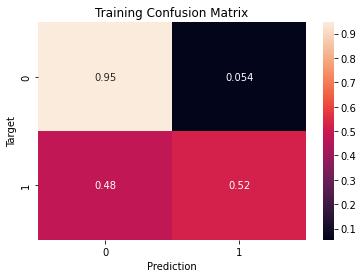

In [89]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 85.41%


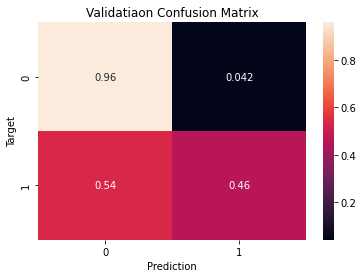

In [90]:
val_preds = predict_and_plot(X_val, val_targets, 'Validatiaon')

Accuracy: 84.22%


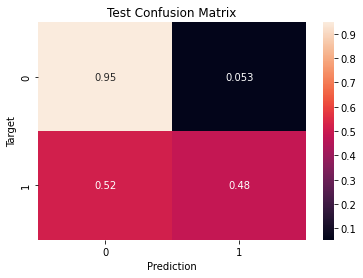

In [91]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')

The accuracy of the model on the test and validation set are above 84%, which suggests that our model generalizes well to data it hasn't seen before. 

While this depends on the nature of the problem and on business requirements, a good way to verify whether a model has actually learned something useful is to compare its results to a "random" or "dumb" model.

Let's create two models: one that guesses randomly and another that always return "No". Both of these models completely ignore the inputs given to them.

In [92]:
def random_guess(inputs):
    return np.random.choice(["No", "Yes"], len(inputs))

def all_no(inputs):
    return np.full(len(inputs), "No")

In [93]:
accuracy_score(test_targets, random_guess(X_test))

0.501905873201089

In [94]:
accuracy_score(test_targets, all_no(X_test))

0.7734344612991054

Our random model achieves an accuracy of 50% and our "always No" model achieves an accuracy of 77%. 

Thankfully, our model is better than a "dumb" or "random" model! This is not always the case, so it's a good practice to benchmark any model you train against such baseline models.

Initialize the `LogisticRegression` model with different arguments and try to achieve a higher accuracy. 

The arguments used for initializing the model are called **hyperparameters** (to differentiate them from weights and biases - parameters that are learned by the model during training).

## **Making Predictions on a Single Input**

Once the model has been trained to a satisfactory accuracy, it can be used to make predictions on new data. 

Consider the following dictionary containing data collected from the Katherine weather department today.

In [97]:
new_input = {'Date': '2021-06-19',
             'Location': 'Katherine',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

new_input_df = pd.DataFrame([new_input])
new_input_df

Date   Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2021-06-19  Katherine     23.2     33.2      10.2          4.2       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... WindSpeed3pm  Humidity9am  \
0         NNW           52.0         NW  ...         20.0         89.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0         58.0       1004.8       1001.5       8.0       5.0     25.7   

   Temp3pm  RainToday  
0     33.0        Yes  

[1 rows x 22 columns]

We've now created a Pandas dataframe with the same columns as `df` (except `RainTomorrow`, which needs to be predicted). The dataframe contains just one row of data, containing the given input.


We must now apply the same transformations applied while training the model:

1. Imputation of missing values using the `imputer` created earlier
2. Scaling numerical features using the `scaler` created earlier
3. Encoding categorical features using the `encoder` created earlier

In [99]:
new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])
X_new_input = new_input_df[numeric_cols + encoded_cols]
X_new_input

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0  0.218105  0.104316  0.000074       0.0002  0.036293      -0.043747   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  WindDir3pm_SE  \
0      0.000769      0.002642       0.0089       0.0058  ...            0.0   

   WindDir3pm_SSE  WindDir3pm_SSW  WindDir3pm_SW  WindDir3pm_W  \
0             0.0             0.0            0.0           0.0   

   WindDir3pm_WNW  WindDir3pm_WSW  WindDir3pm_nan  RainToday_No  RainToday_Yes  
0             0.0             0.0             0.0           0.0            1.0  

[1 rows x 118 columns]

In [102]:
prediction = model.predict(X_new_input)[0]
prediction

'Yes'

In [103]:
prob = model.predict_proba(X_new_input)[0]
prob

array([0., 1.])

Let's define a helper function to make predictions for individual inputs.

In [104]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [106]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [107]:
predict_input(new_input)

C:\Users\Dheeraj\AppData\Local\Temp\ipykernel_24452\2435838903.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Dheeraj\AppData\Local\Temp\ipykernel_24452\2435838903.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Dheeraj\AppData\Local\Temp\ipykernel_24452\2435838903.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragm

('Yes', 0.6476529695007345)

## **Saving and Loading Trained Models**

We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. 

Along with the model, it's also important to save imputers, scalers, encoders and even column names. 

Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk. 

## **Putting it all Together**

While we've covered a lot of ground in this tutorial, the number of lines of code for processing the data and training the model is fairly small. Each step requires no more than 3-4 lines of code.

### **Data Preprocessing**

In [114]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

raw_df = pd.read_csv('./dataset/weatherAUS.csv')
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Create training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]

# Create inputs and targets
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Impute missing numerical values
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

# Scale numeric features
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

# Save processed data to disk
train_inputs.to_parquet('./parquet/train_inputs.parquet')
val_inputs.to_parquet('./parquet/val_inputs.parquet')
test_inputs.to_parquet('./parquet/test_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('./parquet/train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('./parquet/val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('./parquet/test_targets.parquet')

# Load processed data from disk
train_inputs = pd.read_parquet('./parquet/train_inputs.parquet')
val_inputs = pd.read_parquet('./parquet/val_inputs.parquet')
test_inputs = pd.read_parquet('./parquet/test_inputs.parquet')
train_targets = pd.read_parquet('./parquet/train_targets.parquet')[target_col]
val_targets = pd.read_parquet('./parquet/val_targets.parquet')[target_col]
test_targets = pd.read_parquet('./parquet/test_targets.parquet')[target_col]


c:\Users\Dheeraj\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

C:\Users\Dheeraj\AppData\Local\Temp\ipykernel_24452\985335728.py:40: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Dheeraj\AppData\Local\Temp\ipykernel_24452\985335728.py:40: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Dheeraj\AppData\Loca

### **Model Training and Evaluation**

Accuracy: 85.41%
Accuracy: 84.25%


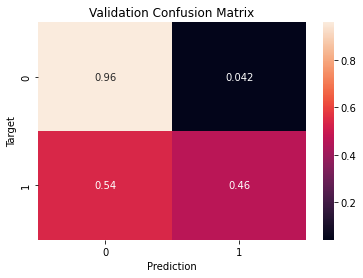

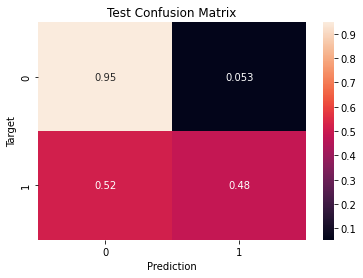

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

# Select the columns to be used for training/prediction
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Create and train the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

# Generate predictions and probabilities
train_preds = model.predict(X_train)
train_probs = model.predict_proba(X_train)
accuracy_score(train_targets, train_preds)

# Helper function to predict, compute accuracy & plot confustion matrix
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));    
    return preds

# Evaluate on validation and test set
val_preds = predict_and_plot(X_val, val_targets, 'Validation')
test_preds = predict_and_plot(X_test, test_targets, 'Test')

# Save the trained model & load it back
aussie_rain = {'model': model, 'imputer': imputer, 'scaler': scaler, 'encoder': encoder,
               'input_cols': input_cols, 'target_col': target_col, 'numeric_cols': numeric_cols,
               'categorical_cols': categorical_cols, 'encoded_cols': encoded_cols}
joblib.dump(aussie_rain, './saved_model/aussie_rain.joblib')
aussie_rain2 = joblib.load('./saved_model/aussie_rain.joblib')

### **Prediction on Single Inputs**

In [117]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

predict_input(new_input)

C:\Users\Dheeraj\AppData\Local\Temp\ipykernel_24452\1630767061.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Dheeraj\AppData\Local\Temp\ipykernel_24452\1630767061.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Dheeraj\AppData\Local\Temp\ipykernel_24452\1630767061.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragm

('Yes', 0.6316590051585192)